In [1]:
%pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=5af33dba351769899745236be07860bff412637f793a565db600716c6e147fbe
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Gerekli kütüphanelerin yüklenmesi
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import numpy as np

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

In [4]:
# Spark session başlatma
spark = SparkSession.builder \
    .appName("California Housing Prices Regression") \
    .config("spark.sql.debug.maxToStringFields", 1000) \
    .getOrCreate()

# Veri setini yükleme
file_path = "/kaggle/input/california-housing-prices/housing.csv"
housing_data = spark.read.csv(file_path, header=True, inferSchema=True)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/02 18:33:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
spark

In [6]:
# Veri setinin ilk 5 satırını görüntüleme
housing_data.show(5)


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [7]:
# Eksik değerlerin kontrol edilmesi ve eksik değer içeren sütunların belirlenmesi
missing_col = {}
for col_name in housing_data.columns:
    missing_count = housing_data.where(col(col_name).isNull()).count()
    if missing_count > 0:
        missing_col[col_name] = missing_count

# Eksik değer içeren sütunların ve eksik değer sayılarının listelenmesi
print("Eksik Değer İçeren Sütunlar ve Sayıları:")
for col_name, count in missing_col.items():
    print(col_name, ": ", count)


Eksik Değer İçeren Sütunlar ve Sayıları:
total_bedrooms :  207


In [8]:
# total_bedrooms sütunundaki eksik değerleri içeren satırların bulunması
missing_bedrooms_rows = housing_data.where(col("total_bedrooms").isNull()).limit(5)

# Sonuçların görüntülenmesi
missing_bedrooms_rows.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.16|   37.77|              47.0|     1256.0|          NULL|     570.0|     218.0|        4.375|          161900.0|       NEAR BAY|
|  -122.17|   37.75|              38.0|      992.0|          NULL|     732.0|     259.0|       1.6196|           85100.0|       NEAR BAY|
|  -122.28|   37.78|              29.0|     5154.0|          NULL|    3741.0|    1273.0|       2.5762|          173400.0|       NEAR BAY|
|  -122.24|   37.75|              45.0|      891.0|          NULL|     384.0|     146.0|       4.9489|          247100.0|       NEAR BAY|
|   -122.1|   37.69|              

In [9]:
# Veri setinin istatistiksel özetini görüntüleme
housing_data.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           NULL|
| stddev|  2.0035317

In [10]:
# Veri setinin şemasını kontrol etme
housing_data.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [11]:
# ocean_proximity sütunundaki benzersiz değerlerin ve sayılarının bulunması
unique_values_counts = housing_data.groupBy("ocean_proximity").count().orderBy("count", ascending=False)

# Sonuçları görüntüleme
unique_values_counts.show()

+---------------+-----+
|ocean_proximity|count|
+---------------+-----+
|      <1H OCEAN| 9136|
|         INLAND| 6551|
|     NEAR OCEAN| 2658|
|       NEAR BAY| 2290|
|         ISLAND|    5|
+---------------+-----+



In [12]:
housing_data = housing_data.drop("longitude", "latitude")

In [13]:
# Adjust the values of `medianHouseValue`
housing_data = housing_data.withColumn("median_house_value", col("median_house_value")/100000)

In [14]:
splits = housing_data.randomSplit([0.7, 0.3])
train = splits[0]
test = splits[1]
train_rows = train.count()
test_rows = test.count()
print("Training Rows:", train_rows, " Testing Rows:", test_rows)


Training Rows: 14491  Testing Rows: 6149


In [15]:
# Tüm numerik sütunların seçilmesi
numeric_columns = [col for col, dtype in housing_data.dtypes if dtype != "string"]

In [16]:
numeric_columns

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

In [17]:
# Get the columns and their data types
column_types = train.dtypes

# Identify categorical columns
categorical_columns = [col_name for col_name, col_type in column_types if col_type == 'string']

# Print the categorical columns
print("Categorical Columns:")
for col_name in categorical_columns:
    print(col_name)


Categorical Columns:
ocean_proximity


In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.sql.functions import col, round

# Eksik değerleri içeren satırların droplanması ve sayısal sütunların yuvarlanması
train = train.na.drop()
for numeric_col in numeric_columns:
    train = train.withColumn(numeric_col, round(col(numeric_col), 2))

# Pipeline'in bileşenlerini tanımlama
encoding = [StringIndexer(inputCol=col, outputCol=col+"_encoded", handleInvalid="keep") for col in categorical_columns]

# VectorAssembler kullanarak tüm sütunları birleştirme
assembler_inputs = numeric_columns + [col + "_encoded" for col in categorical_columns]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# StandardScaler ile sayısal sütunları ölçeklendirme
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Pipeline oluşturma
pipeline = Pipeline(stages=encoding + [assembler, scaler])

# Pipeline'i kullanarak train veri setini dönüştürme
transformed_train = pipeline.fit(train).transform(train)

# Kategorik sütunları çıkar
transformed_train = transformed_train.drop(*categorical_columns)

# İlk 5 satırı gösterme
transformed_train.show(5)


+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------+--------------------+--------------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity_encoded|            features|     scaled_features|
+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------+--------------------+--------------------+
|               1.0|        6.0|           2.0|       8.0|       2.0|         1.63|              0.55|                    1.0|[1.0,6.0,2.0,8.0,...|[-2.1913305612386...|
|               1.0|     2062.0|         343.0|     872.0|     268.0|         5.26|              1.91|                    1.0|[1.0,2062.0,343.0...|[-2.1913305612386...|
|               1.0|     2254.0|         328.0|     402.0|     112.0|         4.25|              1.89|                    1.0|[1.0,2254.0,328.0...|[-2.1913

In [19]:
transformed_train.columns

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity_encoded',
 'features',
 'scaled_features']

In [20]:
# Eksik değerleri içeren satırların droplanması ve sayısal sütunların yuvarlanması
test = test.na.drop()
for numeric_col in numeric_columns:
    test = test.withColumn(numeric_col, round(col(numeric_col), 2))

# Pipeline'i kullanarak test veri setini dönüştürme
transformed_test = pipeline.fit(test).transform(test)

# Kategorik sütunları çıkar
transformed_test = transformed_test.drop(*categorical_columns)

# İlk 5 satırı gösterme
transformed_test.show(5)


+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------+--------------------+--------------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity_encoded|            features|     scaled_features|
+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------+--------------------+--------------------+
|               1.0|       83.0|          15.0|      32.0|      15.0|         4.88|              1.42|                    1.0|[1.0,83.0,15.0,32...|[-2.2019973910281...|
|               2.0|      158.0|          43.0|      94.0|      57.0|         2.56|               0.6|                    3.0|[2.0,158.0,43.0,9...|[-2.1226164094574...|
|               2.0|      337.0|          55.0|     115.0|      49.0|          3.1|              1.65|                    1.0|[2.0,337.0,55.0,1...|[-2.1226

In [21]:
cols = ["housing_median_age","total_rooms","total_bedrooms","population","households","median_income",
                        "median_house_value","ocean_proximity_encoded"]

In [22]:
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [23]:
# LinearRegression modeli oluşturma
lr = LinearRegression(featuresCol='scaled_features', labelCol="median_house_value", predictionCol='pred')

In [24]:
# Parametre gridini belirleme
paramGrid = (ParamGridBuilder()
             .addGrid(lr.maxIter, [5, 10, 20])
             .addGrid(lr.regParam, [0.1, 0.3, 0.5])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

# CrossValidator oluşturma
evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="pred", metricName="rmse")
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)



In [25]:
# Modeli eğitme
cvModel = crossval.fit(transformed_train)

24/04/02 18:33:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/02 18:33:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [26]:
# En iyi modeli seçme
bestModel = cvModel.bestModel

# En iyi modelin performansını değerlendirme
predictions = bestModel.transform(transformed_test)
rmse = evaluator.evaluate(predictions)

# RMSE değerini yazdırma
print("Best Model RMSE:", rmse)

Best Model RMSE: 0.10961378476421202


In [27]:
# Coefficients for the model
bestModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.0, 0.0, 0.0283, 1.0367, 0.0])

In [28]:
# Intercept for the model
bestModel.intercept

2.062355360379198

In [29]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + cols, "Co-efficients": np.insert(bestModel.coefficients.toArray(), 0, bestModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]

In [30]:
coeff_df


,Feature,Co-efficients
0,Intercept,2.062355
1,housing_median_age,0.000000
2,total_rooms,0.000000
3,total_bedrooms,0.000000
4,population,0.000000
5,households,0.000000
6,median_income,0.028251
7,median_house_value,1.036718
8,ocean_proximity_encoded,0.000000


In [31]:
# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("pred", "median_house_value")
predandlabels.show()


+------------------+------------------+
|              pred|median_house_value|
+------------------+------------------+
|1.4829385400681017|              1.42|
|0.7164971003554286|               0.6|
|1.6620840254621196|              1.65|
| 4.732277755293927|               5.0|
| 3.009085768376122|               3.1|
|3.0162919154454833|              3.15|
| 4.190413069046512|               4.5|
|2.9151331724669527|              2.99|
|1.8900230045330464|              1.88|
|1.9904390857205623|              1.97|
|2.1886631432711785|              2.19|
|3.1884183839772042|               3.3|
|1.1892480450928162|              1.12|
|1.4935748894318142|              1.44|
|  1.84933159112136|              1.81|
| 4.756895620683787|               5.0|
| 2.192665936092713|              2.21|
|1.5582945187629456|              1.51|
| 1.764416467428487|              1.74|
|1.7192403062529935|              1.68|
+------------------+------------------+
only showing top 20 rows



In [32]:
# Get the RMSE
print("RMSE: {0}".format(bestModel.summary.rootMeanSquaredError))
print("MAE: {0}".format(bestModel.summary.meanAbsoluteError))
# Get the R2
print("R2: {0}".format(bestModel.summary.r2))

RMSE: 0.09716588491671344
MAE: 0.07639188743044076
R2: 0.9928769701533311


In [33]:
evaluator = RegressionEvaluator(predictionCol="pred", labelCol='median_house_value', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))

RMSE: 0.10961378476421202


<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Gerçek Etiketler')

Text(0, 0.5, 'Tahminler')

Text(0.5, 1.0, 'Gerçek Etiketler vs. Tahminler')

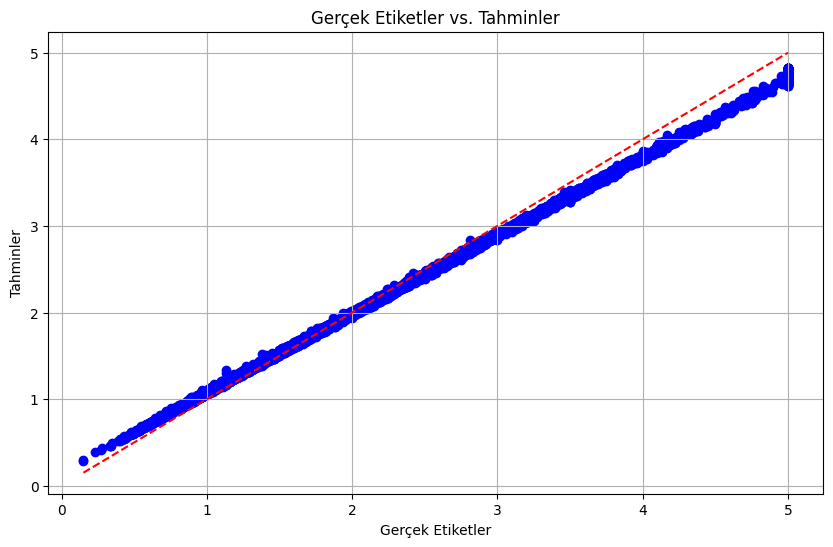

RMSE: 0.10961378476421202


In [34]:
import matplotlib.pyplot as plt

# Tahminler ve gerçek etiketlerle DataFrame oluşturma
predandlabels = predictions.select("pred", "median_house_value")

# RMSE değerini hesaplama
evaluator = RegressionEvaluator(predictionCol="pred", labelCol='median_house_value', metricName='rmse')
rmse = evaluator.evaluate(predandlabels)

# Grafik çizimi için tahmin ve gerçek etiketleri bir listeye dönüştürme
pred_values = [row['pred'] for row in predandlabels.collect()]
label_values = [row['median_house_value'] for row in predandlabels.collect()]

# Grafik çizimi
plt.figure(figsize=(10, 6))
plt.scatter(label_values, pred_values, color='blue')
plt.plot([min(label_values), max(label_values)], [min(label_values), max(label_values)], linestyle='--', color='red')
plt.xlabel('Gerçek Etiketler')
plt.ylabel('Tahminler')
plt.title('Gerçek Etiketler vs. Tahminler')
plt.grid(True)
plt.show()

# RMSE değerini yazdırma
print("RMSE:", rmse)


In [35]:
spark.stop()